# Quantum Teleportation

## The circuit

In this first lab lecture we will see how to simulate quantum teleportation using `Qiskit`.

First, let's create the quantum circuit we need:

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# one register of 3 qubits
qr1 = QuantumRegister(2, name='a')
qr2 = QuantumRegister(1, name='b')
# 2 registers of 1 bit each
cr1 = ClassicalRegister(1, name='cr1')
cr2 = ClassicalRegister(1, name='cr2')
# quantum circuit
teleportation_circuit = QuantumCircuit(qr1, qr2, cr1, cr2)

In order to do teleportation we must give Alice and Bob an entangled pair.

In [2]:
def bellPair(qc, a, b):
    '''
    Creates a bell pair in qc using qubits a & b
    '''
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target

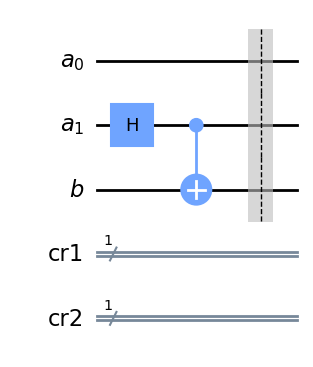

In [3]:
bellPair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

Now Alice and Bob shares the entangled couple $|a_1 \rangle$, $|b \rangle$.

The goal of Alice is to send the qubit $|a_0 \rangle$ to Bob.
In order to do this, Alice will do:

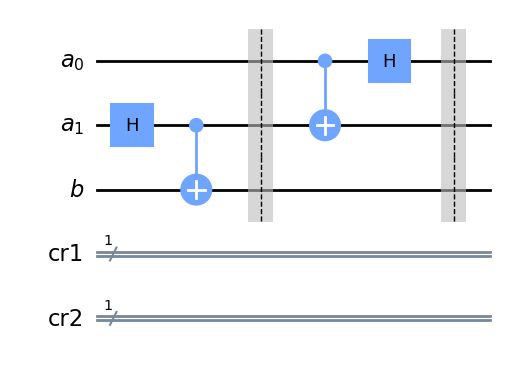

In [5]:
teleportation_circuit.cx(0,1)
teleportation_circuit.h(0)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

Now, Alice needs to send also two classical bits to Bob in order to permit him to adjust the received bit.

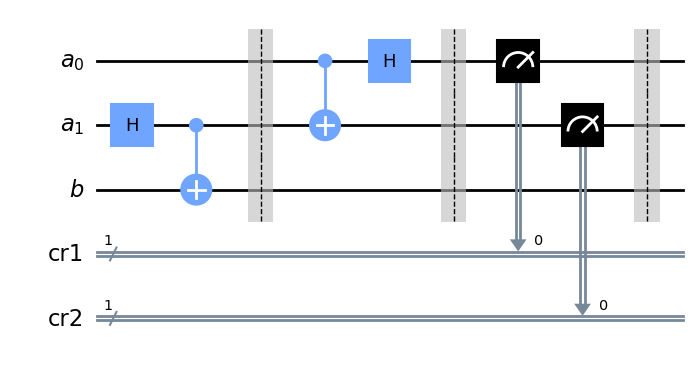

In [6]:
teleportation_circuit.measure(0,0)
teleportation_circuit.measure(1,1)
teleportation_circuit.barrier()
teleportation_circuit.draw(output='mpl')

At this moment Bob has all he needs in order to get the original state $|a_0 \rangle$.

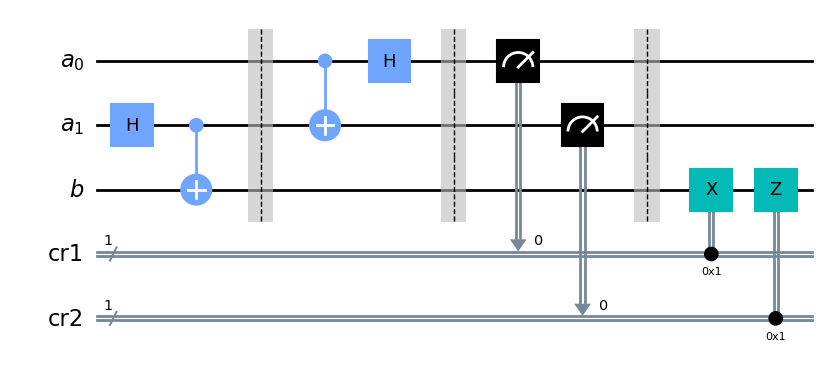

In [7]:
teleportation_circuit.x(2).c_if(cr1, 1)
teleportation_circuit.z(2).c_if(cr2, 1)
teleportation_circuit.draw(output='mpl')

The circuit is complete: Alice's qubit has correctly been sent to Bob.

## Simulate the teleportation protocol

In [ ]:
from qiskit.quantum_info import random_statevector
from qiskit.visualization import plot_bloch_multivector, array_to_latex

# Create a random state to teleport
psi = random_statevector(2)

